In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\chadh\AppData\Local\Temp\ipykernel_13532\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

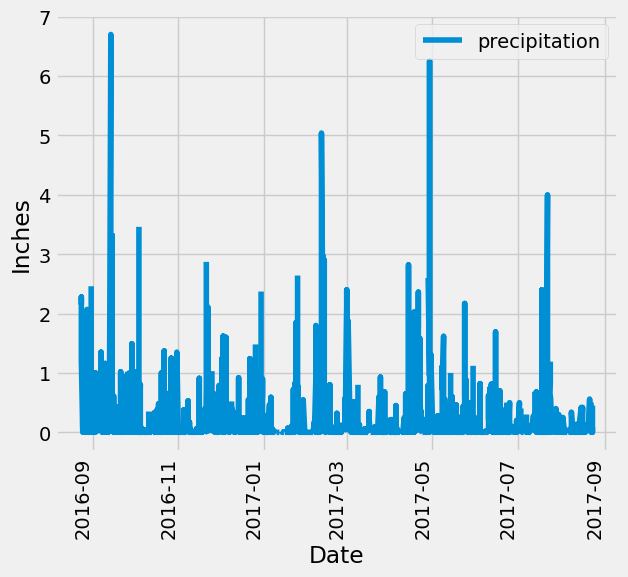

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('date', inplace=True)
precipitation_df.plot(y='precipitation', figsize=(6.5, 6), legend=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_stats = precipitation_df['precipitation'].describe()
precipitation_summary_df = pd.DataFrame(precipitation_summary_stats)
precipitation_summary_df

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


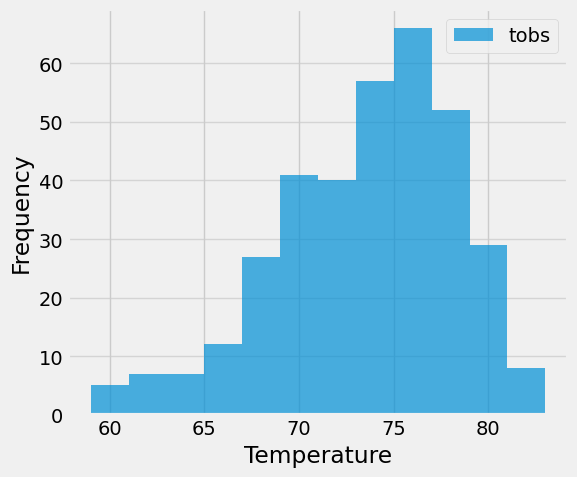

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    all()

temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])

plt.figure(figsize=(6, 5))
plt.hist(temperature_df['temperature'], bins=12, alpha=0.7, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.legend()
plt.show()


# Close Session

In [55]:
# Close Session
session.close()